# Getting and preprocessing faces data

* https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data
* https://www.kaggle.com/datasets/msambare/fer2013
* https://blog.devgenius.io/facial-expression-recognition-with-tensorflow-90f6174163c3
  * https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

In [2]:
import numpy as np
np.__version__

'1.22.3'

In [3]:
import pandas as pd

In [4]:
FER2013_CSV_PATH = "/home/olli/cv/fer2013/fer2013.csv"

In [5]:
label_names = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [6]:
filtered_label_names = ["Angry", "Happy", "Sad", "Surprise", "Neutral"]

In [7]:
df = pd.read_csv(FER2013_CSV_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [8]:
df["emotion"].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [9]:
def plot_data(data, classes):
  
  values = data["emotion"].value_counts().sort_index(ascending=True)

  plt.bar(x=classes, height=values, edgecolor='black')

  plt.xlabel("Emotions")
  plt.ylabel("Amount")
  plt.title("Amount of emotions")
  plt.show();

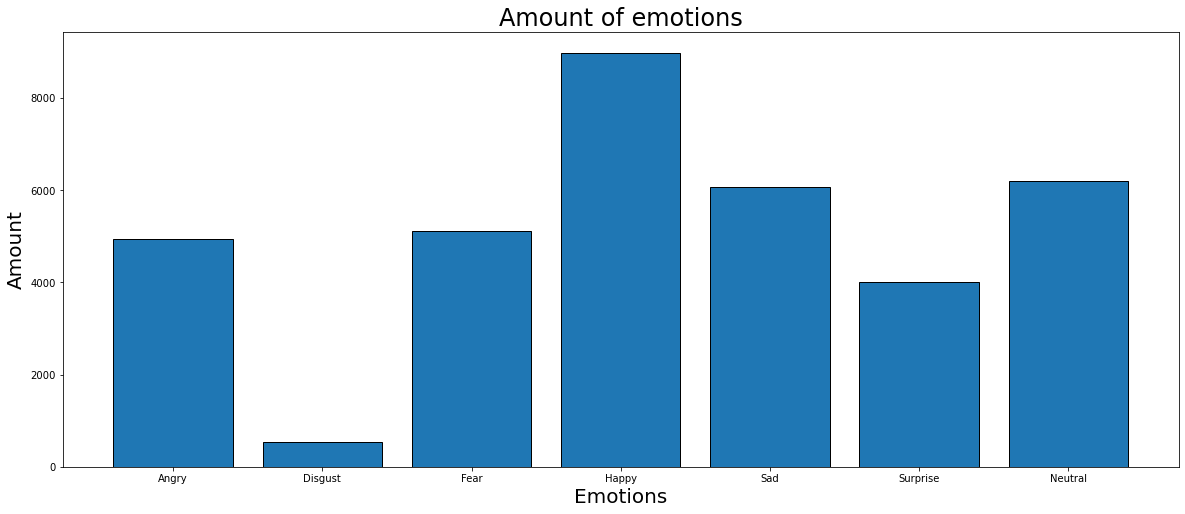

In [10]:
plot_data(df, label_names)

taking advice from 

https://github.com/joaopdss/FacialExpressionRecognition/blob/main/Facial_expression_recognition%20.ipynb

we leave out fear and disgust because they are hard to produce, plus disgust has few samples only

In [11]:
df["emotion"]

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

In [12]:
filtered_df = df[df["emotion"].isin([0, 3, 4, 5, 6, 7])] 
filtered_df["emotion"]

0        0
1        0
3        4
4        6
6        4
        ..
35881    0
35882    6
35883    3
35884    0
35885    3
Name: emotion, Length: 30219, dtype: int64

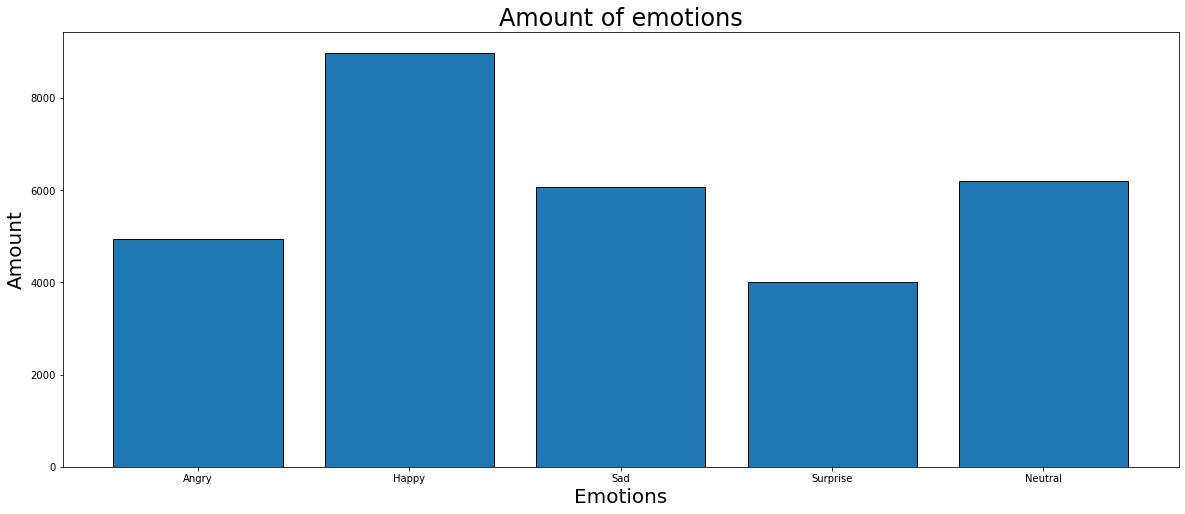

In [13]:
plot_data(filtered_df, filtered_label_names)

In [14]:
df = filtered_df

In [15]:
pixels = df["pixels"]
len(pixels)

30219

In [16]:
resolution = (48, 48)
def image_from_pixels(pixels):
    image = np.reshape(np.array(pixels.split(), 'float64'), resolution)
    return image

In [17]:
%%time

images = np.array([image_from_pixels(p) for p in pixels])
images.shape

CPU times: user 8.51 s, sys: 468 ms, total: 8.98 s
Wall time: 8.98 s


(30219, 48, 48)

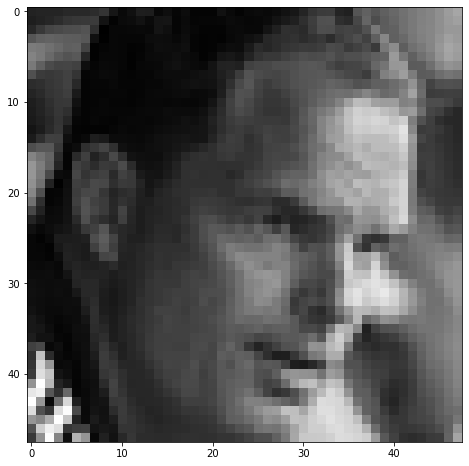

In [18]:
plt.imshow(images[100], cmap='gray');

In [19]:
labels = df["emotion"].values

In [20]:
labels.shape

(30219,)

In [21]:
X = images
y = labels

In [22]:
def plot_gallery(X, y, label_names, size=15):

    population = X.shape[0]
    if size and size < population:
        samples = np.random.choice(population, size=size, replace=False)
    else:
        # just all
        samples = np.arange(0, population)

    for idx, i in enumerate(samples):
        ax = plt.subplot(3, 5, idx + 1)
        image = X[i]
        plt.imshow(image, cmap='gray')
        y_true = y[i]
        plt.title(label_names[y_true])
        plt.axis("off")

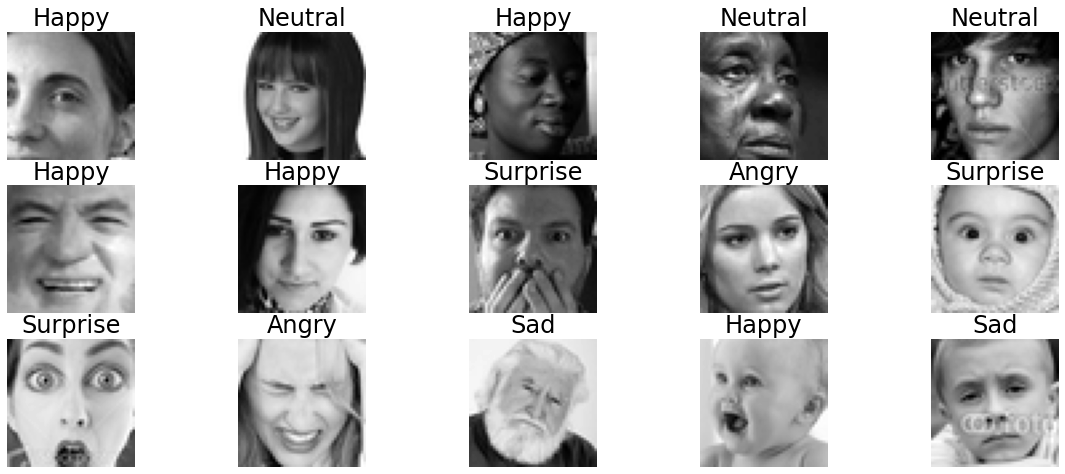

In [23]:
plot_gallery(X, y, label_names)

# Preparing Training

In [24]:
images.shape, images.dtype

((30219, 48, 48), dtype('float64'))

In [25]:
# images encoded as 0..255 bit maps
# neural networks can deal with bytes, but like floats close to 0 better
images.max(), images.min()

(255.0, 0.0)

In [26]:
# sometimes numpy is just great: broadcast
images_normlized = images / 255.0

# we also need to expand images, as the prebuild networks expect that
images_normlized = np.expand_dims(images_normlized, axis=-1)

In [27]:
images_normlized.shape, images_normlized.dtype, images_normlized.max(), images_normlized.min()

((30219, 48, 48, 1), dtype('float64'), 1.0, 0.0)

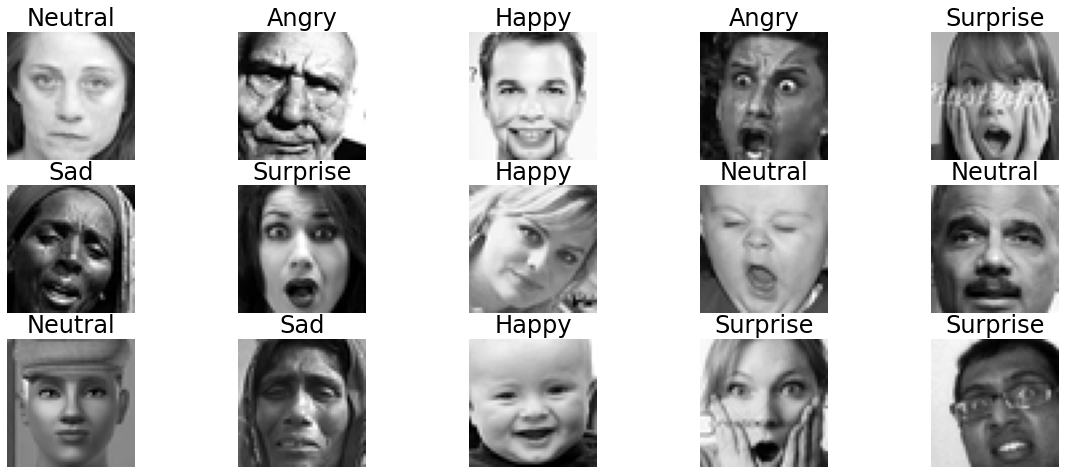

In [28]:
# our default tools are still flexible enough to work with this

plot_gallery(images_normlized, y, label_names)

In [29]:
input_shape=(48, 48, 1)

In [30]:
np.unique(labels)

array([0, 3, 4, 5, 6])

In [31]:
num_classes = labels.max() + 1

# What kind of model should we use?

* Coming up with a decent CNN architecture is a research topic
* Using a prebuilt architecture often is the best choice
  * https://keras.io/api/applications/
* however, accuracy is not the only metric we are concerned about
  * we also need this to be portable to run in the browser in the first place, plus
  * we need this to react in near real time to be useable
  * training any default architecture on CPU is simply not feasible
  * do we have a GPU availble for training 
  * which one, how powerful?

In [32]:
import tensorflow as tf
tf.__version__

2022-10-25 21:02:04.977237: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-25 21:02:04.987580: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 21:02:04.987620: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.9.1'

In [33]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [34]:
tf.config.list_physical_devices('GPU')

[]

2022-10-25 21:02:06.680855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-25 21:02:06.680949: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-25 21:02:06.680968: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BEN73DP): /proc/driver/nvidia/version does not exist


In [35]:
# ResNet50?

In [36]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

# model = ResNet50(weights='imagenet')
model = ResNet50(weights=None, input_shape=input_shape, classes=num_classes)

2022-10-25 21:02:06.728763: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [37]:
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten

model = tf.keras.Sequential()

model.add(InputLayer(input_shape=input_shape, name='input'))

model.add(Conv2D(filters=32, kernel_size=3, activation='relu')) 
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.7))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.7))
model.add(Dense(num_classes, activation='softmax'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

0

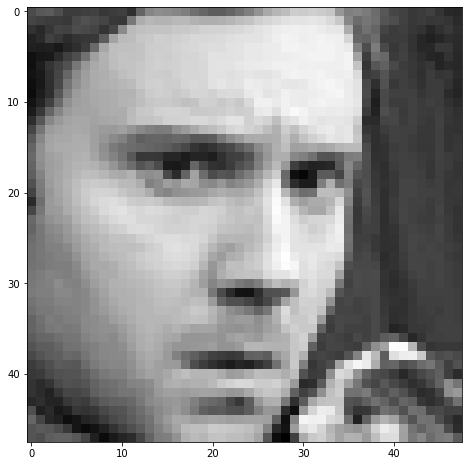

In [39]:
# labels: "Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"
img = images[0]
plt.imshow(img, cmap='gray');
labels[0]

In [40]:
# From docs: The images are converted from RGB to BGR, then each color channel is 
# zero-centered with respect to the ImageNet dataset, without scaling.

# preprocess_input?

In [41]:
# this is what ImageNet dataset looks like, but for the rest of the world this is just weird
# so let's not do this
x = preprocess_input(img.copy())
x.shape, x.dtype, x.min(), x.max()

((48, 48), dtype('float64'), -84.68, 210.0)

In [42]:
X = images_normlized
y = labels

In [43]:
# we play be our own rules, we do our own split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24175, 48, 48, 1), (6044, 48, 48, 1), (24175,), (6044,))

In [44]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [45]:
%%time

from lrcurve import KerasLearningCurve

BATCH_SIZE = 50
# EPOCHS = 500
EPOCHS = 75

history = model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    shuffle=True,
                    validation_split=0.2,
                    callbacks=[KerasLearningCurve()],
                    verbose=0
                    )

CPU times: user 1h 22min 6s, sys: 5min 22s, total: 1h 27min 28s
Wall time: 19min 7s


In [46]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE, verbose=0)
train_loss, train_accuracy

(0.7618553638458252, 0.7236815094947815)

In [47]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
test_loss, test_accuracy

(0.9598573446273804, 0.6260754466056824)

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(model, X, y, file_name=None):
    y_pred = model.predict(X, batch_size=BATCH_SIZE).argmax(axis=1)
    cm = confusion_matrix(y, y_pred)
    figure = plt.figure(figsize=(10, 10))

    sns.heatmap(cm, annot=True, xticklabels=label_names, yticklabels=label_names, cmap='Blues', fmt='d')
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

ModuleNotFoundError: No module named 'seaborn'

In [49]:
def plot_accuracy(history, file_name=None):
    plt.figure()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Accuracy', 'Validation Accuracy']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

In [50]:
def plot_loss(history, file_name=None):
    plt.figure()

    plt.xlabel('epochs')
    plt.ylabel('loss')

    plt.yscale('log')

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Loss', 'Validation Loss']);
    if file_name:
        plt.savefig('outputs/%s.png' % file_name)

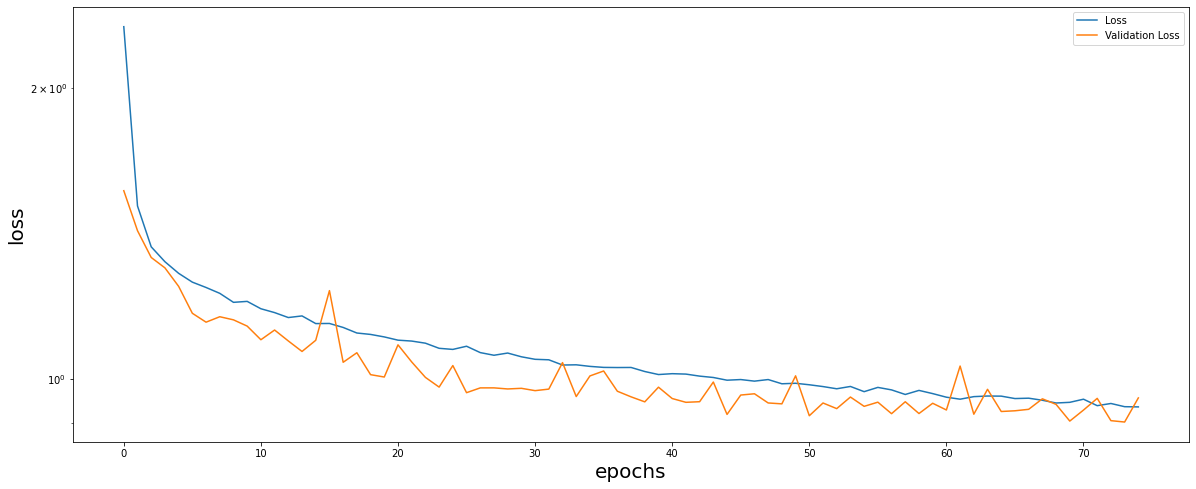

In [51]:
plot_loss(history)

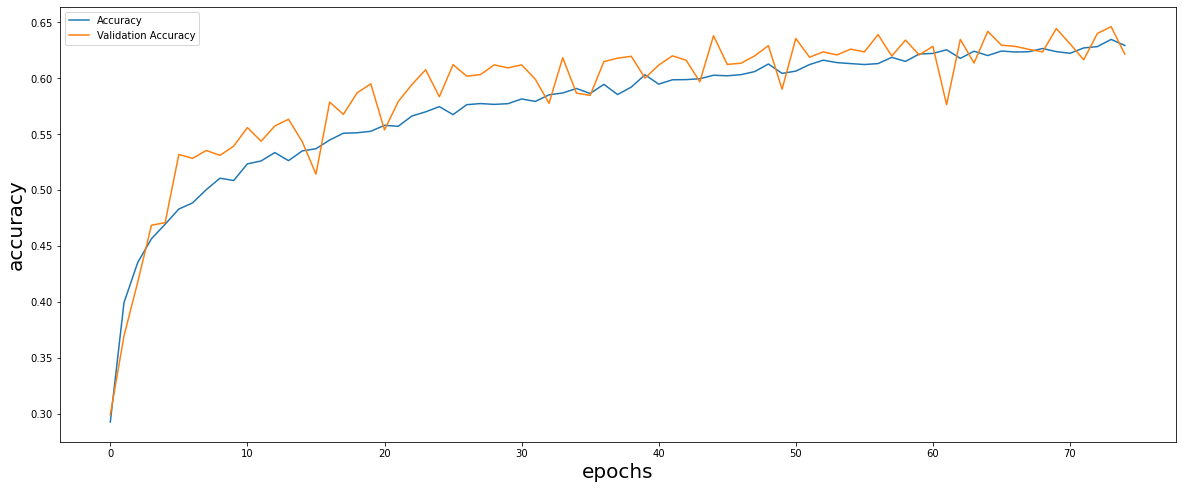

In [52]:
plot_accuracy(history)

In [ ]:
y_pred = model.predict(X).argmax(axis=1)
y_pred